In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.stats import norm
from matplotlib.widgets import Slider, Button, RadioButtons

In [3]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# Распознавание образов, описываемых гауссовскими случайными векторами с одинаковыми матрицами ковариаций 

Рассмотрим случай распознавания образов, описываемых двумерными гауссовскими случайными векторами с матрицами ковариации: 
$$
    C_{1} = 
    \begin{bmatrix}
        8 & -1 \\
        -1 & 8
    \end{bmatrix}, \quad
    C_{2} = 
    \begin{bmatrix}
        5 & 3 \\
        3 & 6
    \end{bmatrix}
$$

Пусть образы могут принадлежать одному из $M = 2$ классов, а матожидания случайных векторов равны

$$
    \vec{m_{1}} = 
    \begin{bmatrix}
         3\\
         1
    \end{bmatrix},\,
    \vec{m_{2}} = 
    \begin{bmatrix}
         -1\\
         7
    \end{bmatrix}
$$

Априорные вероятности появления объекта $i$-го класса считаем равными:
$$
    p(\omega_1) = p(\omega_2) = \dfrac{1}{2}
$$

In [4]:
M = 2

n = 2

m1 = np.array((3, 1))
m2 = np.array((-1, 7))

C1 = np.matrix([(8, -1),(-1, 8)])
C2 = np.matrix([(5, 3),(3, 6)])

m = np.column_stack((m1, m2))
C = np.array((C1, C2))

xMin = m[0, :].min() - 4*np.sqrt(8)
xMax = m[0, :].max() + 4*np.sqrt(8)
yMin = m[1, :].min() - 4*np.sqrt(6)
yMax = m[1, :].max() + 4*np.sqrt(6)

Визуализируем функции плотности вероятностей случайных векторов трех классов:

In [5]:

def drawPdf(plot):
    x, y = np.mgrid[xMin:xMax:0.05, yMin:yMax:0.05]
    pos = np.dstack((x, y))
    
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C[i])
        plot.contour(x, y, rv.pdf(pos))

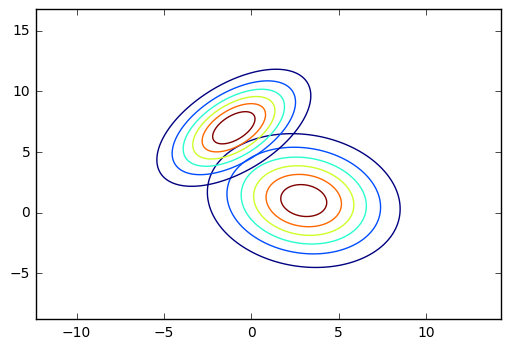

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111)

drawPdf(ax)

plt.show();
plt.clf()

График представляет собой линии уровня поверхностей плотностей распределения случайных векторов. Чем выше уровень, тем больше вероятность реализации случайного вектора с данными координатами

Сформируем по $ n = 400$ случайных величин каждого класса и отобразим их на графике:

In [7]:
n = 400

def gen(m, C, n):

    vals = np.zeros((M, 2, n))
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C[i])
        for j in range(0, n):
            x, y = rv.rvs()
            vals[i, 0:2, j] = rv.rvs()
            
    return vals

def drawPoints(points, plot):
    
    colors = ['r', 'g', 'b']
    
    for i in range(0, M):
        plot.scatter(points[i, 0, :], points[i, 1, :], c=colors[i], s=10)

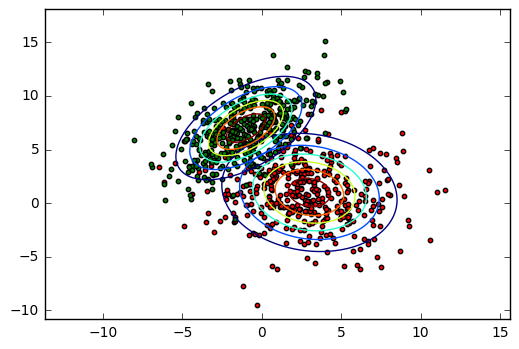

In [8]:
fig = plt.figure()

ax = fig.add_subplot(111)

vals = gen(m, C, n)

drawPoints(vals, ax)
drawPdf(ax)

plt.show()
plt.clf()

Действительно, чем больше плотность распределения в некоторой области, тем выше вероятность реализации случайного вектора этого класса в данной области

# Синтез алгоритма

Воспользуемся разделяющей функцией вида 
\begin{align}
    g_i(\vec{x}) = ln(p(\omega_i)p(\vec{x} / \omega_i)),
\end{align}

где $p(\omega_i)$ - априорная вероятность появления объекта $i$-го класса, а $p(\vec{x} / \omega_i)$ - плотность распределения случайного вектора, описывающего объекты данного класса.

Подставив явный вид $p(x / \omega_i)$ и произведя упрощения, получим

\begin{align}
g_i(\vec{x}) = -\dfrac{1}{2}ln|C_{i}| - \dfrac{1}{2}\vec{x}^{\,T}C_{i}^{-1}\vec{x} + \vec{x}^{\,T}C_{i}^{-1}\vec{m_i} - \dfrac{1}{2}\vec{m_i}^{\,T}C_{i}^{-1}\vec{m_i} + ln(p(\omega_i)), \quad i=\overline{1, M}
\end{align}

Видно, что $g_i(\vec{x})$ - квадратичная функция.

При рассмотрении случайного вектора $\vec{x}$ будем считать, что он принадлежит $i$-му классу, если

\begin{equation}
    g_i(\vec{x}) \geqslant g_j(\vec{x}) \quad \forall j = \overline{1, M}, \quad j \neq i
\end{equation}

Определим функцию $g_{i}(\vec{x})$:

In [9]:
C_ = np.array((C1**-1, C2**-1))

def g(x, i):
    
    x_ = x.transpose()

    mi = m[:, [i]]
    mi_ = m[:, i]
    
    val = -0.5*np.log(np.linalg.det(C[i]))
    val += -0.5*x_.dot(C_[i]).dot(x)
    val += x_.dot(C_[i]).dot(mi)
    val += -0.5*mi_.dot(C_[i]).dot(mi)
    val += np.log(1 / 2)
    
    return val

Уравнение $g_{ij}(\vec{x}) = g_i(\vec{x}) - g_j(\vec{x}) = 0$ задает линию, разделяющую векторы $i$ и $j$ класса.

Так как уравнение $ g_i(\vec{x}) - g_j(\vec{x}) = 0$ задает кривую второго порядка в векторном виде, и сложно явно выразить зависимость $y = f(x)$ для построения кривой на плоскости, рассчитаем значения функции $g_{ij}(\vec{x}) = g_i(\vec{x}) - g_j(\vec{x})$ и отобразим линию уровня, равного 0:

In [41]:
def drawLines(plot):

    x,y = np.mgrid[xMin:xMax:0.5, yMin:yMax:0.5]
    xy = np.vstack([ x.reshape(-1), y.reshape(-1) ])
    
    lenX, lenY = x.shape
    
    for i in range(0, M):
        for j in range(i+1, M):
            
            arr = np.zeros((lenX*lenY))
            for k in range(0, lenX*lenY):
            
                x_ = xy[:, [k]]
                
                arr[k] = g(x_, i) - g(x_, j)
                
            ax.contour(x, y, arr.reshape((lenX, lenY)), 0)

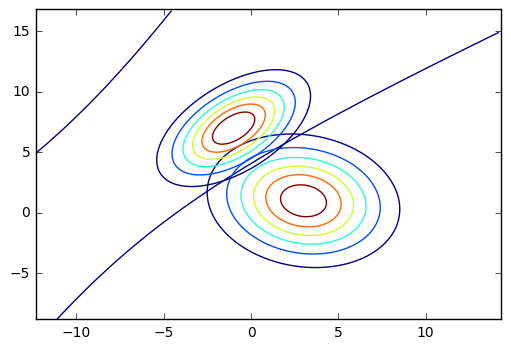

In [42]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis((xMin, xMax, yMin, yMax))

drawLines(ax)

drawPdf(ax)

plt.show()
plt.clf()

По графику видно, что данная кривая действительно разделяет два класса

# Статистические испытания

Для каждого класса сформируем $k = 5000$ случайных векторов и выполним распознавание с помощью синтезированного алгоритма.
Построим матрицу ошибок $E$ , в которой на пересечении $i$ строки и $j$ столбца находится вероятность того, что при распознавании объекта $i$ класса было принято решение о том, что это объект $j$ класса.

In [12]:

k = 5000

def errMatrix(k):
    err = np.zeros((M, M))
    u = np.zeros((M))
    for i in range(0, M):
        rv = multivariate_normal(m[:, i], C[i])
        for j in range(0, k):
            x, y = rv.rvs()
            vec = np.array([[x], [y]])
            for z in range(0, M):
                u[z] = g(vec, z)
                
            res = u.argmax()
            err[i, res] += 1
    return err / k

In [31]:
err = errMatrix(k)

summErr = err[0, 1] + err[1, 0]

print("Матрица ошибок:")
print(err)
print("Суммарная вероятность ошибки:\n", summErr)

Матрица ошибок:
[[0.93 0.07]
 [0.03 0.97]]
Суммарная вероятность ошибки:
 0.1044


# Теоретическая матрица ошибок

Рассчитаем теоретическую матрицу ошибок:

In [15]:

def tErrorMatrix():
    err1 = np.zeros((M, M))

    for i in range(0, M):
        for j in range(i + 1, M):
            mij = m[:, [i]] - m[:, [j]]
            mij_ = mij.transpose()
            
            deti = np.linalg.det(C[i])
            detj = np.linalg.det(C[j])
            
            trij = np.trace(C_[j].dot(C[i]) - np.eye(2))
            trji = np.trace(np.eye(2) - C_[i].dot(C[j]))
            
            mg1 = 0.5*(trij + mij_.dot(C_[j]).dot(mij) - np.log(deti/detj))
            dg1 = 0.5*trij**2 + mij_.dot(C_[j]).dot(C[i]).dot(C_[j]).dot(mij)
            
            mg2 = 0.5*(trji - mij_.dot(C_[i]).dot(mij) + np.log(detj/deti))
            dg2 = 0.5*trji**2 + mij_.dot(C_[i]).dot(C[j]).dot(C_[i]).dot(mij)
            
            err1[i, j] = norm.cdf(0, mg1, np.sqrt(dg1))
            err1[j, i] = 1 - norm.cdf(0, mg2, np.sqrt(dg2))
            
        err1[i, i] = 1 - err1[i, :].sum()
    return err1

In [27]:
err = tErrorMatrix()

summErr = err[0, 1] + err[1, 0]

print("Матрица ошибок:")
print(err)
print("Суммарная вероятность ошибки:\n", summErr)

Матрица ошибок:
[[0.89 0.11]
 [0.01 0.99]]
Суммарная вероятность ошибки:
 0.123317111266


Вычислим теоретическу матрицу ошибок с использованием верхней границы Чернова:

In [29]:
def t1ErrorMatrix():
    err1 = np.zeros((M, M))

    for i in range(0, M):
        for j in range(i + 1, M):
            mij = m[:, [i]] - m[:, [j]]
            mij_ = mij.transpose()
            
            deti = np.linalg.det(C[i])
            detj = np.linalg.det(C[j])
            
            mu2 = (1/8)*mij_.dot(np.linalg.inv(C[i]/2 + C[j]/2)).dot(mij)+0.5*np.log((deti + detj)/(2*np.sqrt(deti*detj)))
            
            err1[i, j] = np.exp(-mu2)
            err1[j, i] = np.exp(-mu2)
            
        err1[i, i] = 1 - err1[i, :].sum()
    return err1

In [30]:
err = t1ErrorMatrix()

summErr = err[0, 1] + err[1, 0]
print("Матрица ошибок:")
print(err)
print("Суммарная вероятность ошибки:\n", summErr)

Матрица ошибок:
[[0.69 0.31]
 [0.31 0.69]]
Суммарная вероятность ошибки:
 0.615380249366


Видно, что теоретическая матрица ошибок на основе границы Чернова дает результат, далекий от полученных при имитационном моделировании, а матрица, основанная на гауссовской аппроксимации, достаточно близка к нему.